# Main Functions

In [26]:
'''
INPUT:   G = directed or undirected graph with vertices labeled 0,...,(n-1)
OUTPUT:  a zero forcing set & throttling number
'''
def throttle(G):
    n = G.order()
    nbrs = get_out_nbrs(G, G.is_directed())
    
    throt_num = n
    zfs = [x for x in range(n)]
    
    for b in range(1,n):
        for B in Combinations(range(n), b):
            filled, prop_time = push_zeros(nbrs, B, n)
            if len(filled) == n:  # all blue?
                if b + prop_time < throt_num:
                    zfs = B
                    throt_num = b + prop_time
                    
        if throt_num < b + 1:
            return zfs, throt_num
        
    return zfs, throt_num

'''
INPUT:   G = directed/oriented graph with vertices labeled 0,...,(n-1)
         B = List of a subset of V(G)
         wantChains (optional arg, False by default) = whether to output forcing chains
OUTPUT:  prop_time = pt(G;B) (returns math.inf if infinite)
         chains (optional) = maximal forcing chains when forcing G using B
'''
def prop_time(G, B, wantChains=False):
    nbrs = get_out_nbrs(G, G.is_directed())
    n = G.order()
    if wantChains:
        filled, prop_time, chains = push_zeros(nbrs, B, n, wantChains=True)
    else:
        filled, prop_time = push_zeros(nbrs, B, n)
        
    if len(filled) != n:
        prop_time = math.inf
    
    if wantChains:
        return prop_time, chains
    return prop_time

'''
INPUT:   chains = 2-d array of maximal forcing chains
OUTPUT:  the terminus, aka the last vertices of the forcing chains
'''
def get_terminus(chains):
    return [chain[-1] for chain in chains]

'''
INPUT:   G = undirected graph
OUTPUT:  [m, M] = orientation throttling interval 
'''
def throt_intvl(G):
    n = G.order()
    orientations = G.orientations()
    
    min_throt = n
    max_throt = 0
    
    for i in range(2**(G.size())):
        H = next(orientations)
        zfs, throt_num = throttle(H)
        if throt_num < min_throt:
            min_throt = throt_num
        if throt_num > max_throt:
            max_throt = throt_num
    return min_throt, max_throt

### Specific Graph Functions

In [27]:
'''
INPUT:   n = number of vertices
OUTPUT:  max throttling number for path on n vertices, list of orientations that achieve that
'''
def max_path_throt(n):
    G = Graph()
    G.add_vertices(range(n))
    G.add_path(range(n))
    orientations = G.orientations()
    
    max_throt = 0
    graphs = []
    
    for i in range(2**(n-1)):
        H = next(orientations)
        zfs, throt_num = throttle(H)
        if throt_num > max_throt:
            graphs = [H]
            max_throt = throt_num
        elif throt_num == max_throt:
            graphs.append(H)
    return max_throt, graphs

'''
INPUT:   n = number of vertices
OUTPUT:  max throttling number for cycle on n vertices, list of orientations that achieve that
'''
def max_cycle_throt(n):
    G = Graph()
    G.add_vertices(range(n))
    G.add_path(range(n))
    G.add_edge(0,n-1)
    orientations = G.orientations()
   
    max_throt = 0
    graphs = []
   
    for i in range(2**n):
        H = next(orientations)
        zfs, throt_num = throttle(H)
        if throt_num > max_throt:
            graphs = [H]
            max_throt = throt_num
        elif throt_num == max_throt:
            graphs.append(H)
    return max_throt, graphs

'''
INPUT:   n = number of vertices
OUTPUT:  throttling number for path on n vertices with alternating edges
'''
def alt_edges_path_throt(n, returnGraph = False):
    G = DiGraph(n)
    edges = []
    source = True
    
    for i in range(n-1):
        if source:
            edges.append((i,i+1))
        else:
            edges.append((i+1,i))
        source = not source
        
    G.add_edges(edges)
    
    if returnGraph:
        return alt_throttle(G)[1], G
    return alt_throttle(G)[1]

'''
INPUT:   G = alternationg path graph with vertices labeled 0,...,(n-1)
OUTPUT:  a zero forcing set & throttling number
'''
def alt_throttle(G):
    n = G.order()
    nbrs = get_out_nbrs(G, G.is_directed())
    
    throt_num = n
    zfs = [x for x in range(n)]
    B_0 = [x for x in range(0,n,2)]
    b_0 = len(B_0)
    
    for b_1 in range(1,n-b_0):
        for B_1 in Combinations(range(1,n,2), b_1):
            B = B_0 + B_1
            b = b_0 + b_1
            filled, prop_time = push_zeros(nbrs, B, n)
            if len(filled) == n:  # all blue?
                if b + prop_time < throt_num:
                    zfs = B
                    throt_num = b + prop_time
                    
        if throt_num < b + 1:
            return zfs, throt_num
        
    return zfs, throt_num

# Helper Functions

In [28]:
'''
INPUT:   G = graph
OUTPUT:  nbrs = list of outneighbors of G (e.g. nbrs[0] = outneighbors of vertex 0)
'''
def get_out_nbrs(G, directed):
    n = G.order()
    nbrs = []  # Find lists of out neighbors (for push_zeros)
    for v in range(n):
        if directed:
            out_nbrs = G.neighbors_out(v)
        else:
            out_nbrs = G.neighbors(v)
        nbrs.append(out_nbrs)
    return nbrs

'''
Adapted from: https://sage.math.iastate.edu/home/pub/74/
INPUT:   nbrs = a list of all out-neighbors of each vertex
         B = an initial set of "blue" vertices
         n = number of vertices in graph
         wantChains (False by default) = whether to output forcing chains or not
OUTPUT:  filled = the set of all vertices forced under repeated
         prop_time = how many iteration of the color change rule
         chains (optional) = 2-d list of maximal forcing chains
'''
def push_zeros(nbrs, B, n, wantChains=False):
    active = set(B)
    filled = set(B)
    unfilled = set(range(n)).difference(filled)
    force = True
    prop_time = -1
    chains = [[v] for v in active]
    
    while force:  # keep going until no more forces happen
        prop_time += 1
        force = False
        
        # copy to be careful with prop time
        new_active = active.copy()
        new_filled = filled.copy()
        new_unfilled = unfilled.copy()
        
        for v in active:  # check each blue vertex which might force
            white_nbrs = set(nbrs[v]).intersection(unfilled)
            if len(white_nbrs) == 0:  # if no white neighbors, remove from active
                new_active.remove(v)
            elif len(white_nbrs) == 1:  # one white neighbor so can force
                w = white_nbrs.pop()
                new_filled.add(w)  # w is now blue
                if w in new_unfilled: # no other vertex in this time step has forced w yet
                    force = True 
                    new_unfilled.remove(w)
                    # Add to forcing chains
                    if wantChains:
                        for chain in chains:
                            if chain[-1] == v:
                                chain.append(w)
                new_active.add(w)
                new_active.remove(v)
        active = new_active.copy()
        filled = new_filled.copy()
        unfilled = new_unfilled.copy()
        
    if wantChains:
        return filled, prop_time, chains
    return filled, prop_time

# Examples
### Tournament on 4 vertices with min throttling num

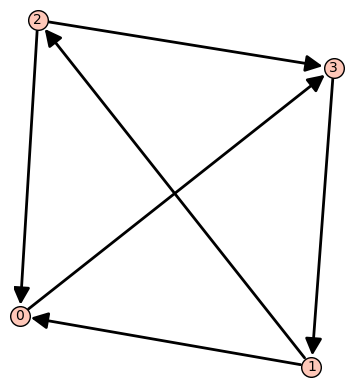

In [29]:
G1=DiGraph(4)
G1.add_edges([(1,0),(3,1),(0,3),(2,0),(2,3),(1,2),(0,3)])
G1.show()

In [30]:
zfs, th = throttle(G1)
print('Throttling Number for G1:', th)
print('Zero Forcing Set:', zfs)

Throttling Number for G1: 3
Zero Forcing Set: [0, 1]


In [31]:
B = [0,2]
pt = prop_time(G1, B)
print('Prop Time for G1 using B:', pt)
pt, chains = prop_time(G1, B, wantChains=True)
print('Forcing Chains for G1 using B:', chains)
term_B = get_terminus(chains)

Prop Time for G1 using B: 2
Forcing Chains for G1 using B: [[0, 3, 1], [2]]


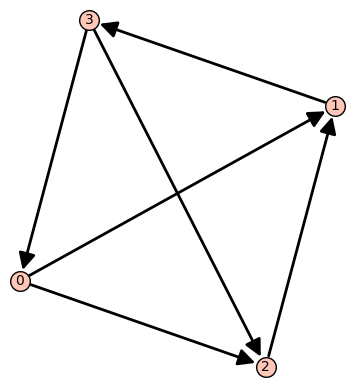

In [32]:
G1_T = G1.reverse()
G1_T.show()

In [8]:
pt, chains = prop_time(G1_T, term_B, wantChains=True)
print('Prop Time for G1^T using Term(B):', pt)
print('Forcing Chains for G1^T using Term(B):', chains)

Prop Time for G1^T using Term(B): 2
Forcing Chains for G1^T using Term(B): [[1, 3, 0], [2]]


### Tournament on 6 vertices with max throttling num

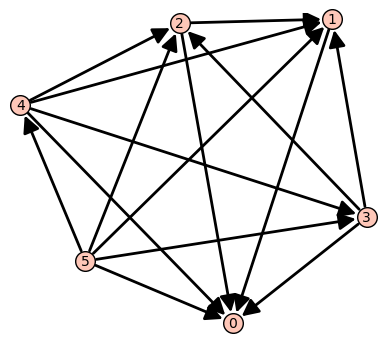

In [9]:
M = matrix([[0,0,0,0,0,0],
            [1,0,0,0,0,0],
            [1,1,0,0,0,0],
            [1,1,1,0,0,0],
            [1,1,1,1,0,0],
            [1,1,1,1,1,0]])
G2 = DiGraph(M)
G2.show() 

In [10]:
zfs, th = throttle(G2)
print('Throttling Number for G2:', th)
print('Zero Forcing Set:', zfs)

Throttling Number for G2: 6
Zero Forcing Set: [0, 1, 2, 3, 4, 5]


### Complete Hessenberg path on 9 vertices

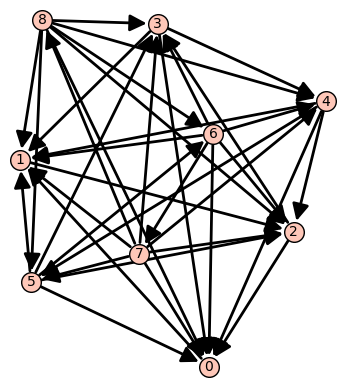

In [11]:
M = matrix([[0,1,0,0,0,0,0,0,0],
            [0,0,1,0,0,0,0,0,0],
            [1,0,0,1,0,0,0,0,0],
            [1,1,0,0,1,0,0,0,0],
            [1,1,1,0,0,1,0,0,0],
            [1,1,1,1,0,0,1,0,0],
            [1,1,1,1,1,0,0,1,0],
            [1,1,1,1,1,1,0,0,1],
            [1,1,1,1,1,1,1,0,0]])
G3 = DiGraph(M)
G3.show() 

In [12]:
zfs, th = throttle(G3)
print('Throttling Number for G3:', th)
print('Zero Forcing Set:', zfs)

Throttling Number for G3: 7
Zero Forcing Set: [0, 2, 5]


### Counterexample to pt(G;B)=pt(G^T;Term(F))

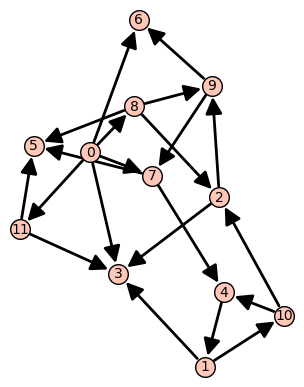

In [13]:
G4 = DiGraph(12)
G4.add_edges([(2,3),(8,2),(0,3),(7,4),(0,8),(1,3),(7,5),(4,1),(8,5),(0,6),(0,7),(2,9),(10,2),(11,3),(1,10),(11,5),(10,4),(8,9),(0,11),(9,6),(9,7)])
G4.show()

In [14]:
B = [0,1,2,5,7,8]
pt, chains = prop_time(G4, B, wantChains=True)
print('Prop Time for G4 using B:', pt)
print('Forcing Chains for G4 using B:', chains)
term_B = get_terminus(chains)
print(term_B)

Prop Time for G4 using B: 3
Forcing Chains for G4 using B: [[0, 11], [1, 10], [2, 3], [5], [7, 4], [8, 9, 6]]
[11, 10, 3, 5, 4, 6]


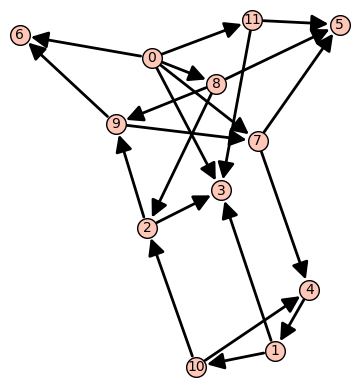

In [15]:
G4_T = G4.reverse()
G4.show()

In [16]:
pt, chains = prop_time(G4_T, term_B, wantChains=True)
print('Prop Time for G4^T using Term(B):', pt)
print('Forcing Chains for G4^T using Term(B):', chains)

Prop Time for G4^T using Term(B): 2
Forcing Chains for G4^T using Term(B): [[3, 2], [4, 7], [5, 8], [6, 9], [10, 1], [11, 0]]


### Upper Bound for Throttling on Paths

In [17]:
max_throt, graphs_list = max_path_throt(8)
print(max_throt)

6


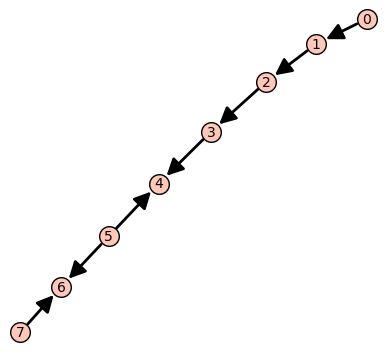

In [18]:
graphs_list[1].show()

In [19]:
for n in range(1, 10):
    throt_num = alt_edges_path_throt(n)
    print(throt_num)

1
2
3
4
5
5
6
6
7


8


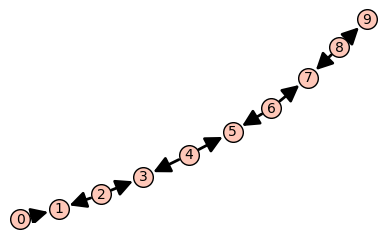

In [20]:
throt_num, G = alt_edges_path_throt(10, returnGraph=True)
print(throt_num)
G.show()

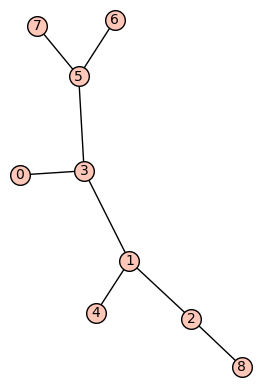

th(G): 6
OTI: [6, 7]


In [21]:
G = Graph(9)
G.add_edges([(1,2),(1,3),(5,6),(1,4),(0,3),(7,5),(8,2),(5,3)])
G.show()

zfs, throt_num = throttle(G)
print('th(G):', throt_num)
m, M = throt_intvl(G)
print('OTI: [' + str(m) + ', ' + str(M) + ']')

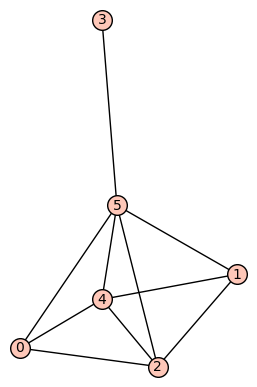

6
OTI: [4, 6]


In [33]:
G = graphs.RandomGNM(6,10)
G.show()
zfs, throt_num = throttle(G)
print(throt_num)
m, M = throt_intvl(G)
print('OTI: [' + str(m) + ', ' + str(M) + ']')